In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.9 MB/s eta 0:00:00


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchmetrics import StructuralSimilarityIndexMeasure

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# U-Net Model Definition
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # k+3 output channels (k for classes, 3 for reconstruction)
        self.final = nn.Conv2d(64, num_classes + 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        bn = self.bottleneck(self.pool(e3))

        d3 = self.up3(bn)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)



Using device: cuda


In [11]:
# Loss Functions
class CompositeLoss(nn.Module):
    def __init__(self, teacher_model):
        super().__init__()
        self.reconstruction_loss = nn.MSELoss()
        self.teacher_model = teacher_model
        self.teacher_model.eval()  # Freeze teacher model
        self.projection = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=1),  # Adjust channels
            nn.AdaptiveAvgPool2d((8, 8))       # Adjust spatial dimensions
        )
        self.projection = self.projection.to(device)

    def distillation_loss(self, student_output, x):
        with torch.no_grad():
            teacher_features = self.teacher_model(x)
        student_features = self.projection(student_output)
        return F.mse_loss(student_features, teacher_features)

    def fuzzy_ncut_loss(self, segmentation_output, epsilon=1e-8):
        B, K, H, W = segmentation_output.shape
        softmax_out = F.softmax(segmentation_output, dim=1)

        loss = 0
        for k in range(K):
            prob = softmax_out[:, k]
            assoc_AV = torch.sum(prob)
            assoc_AA = torch.sum(prob * prob)
            loss += assoc_AA / (assoc_AV + epsilon)
        return K - loss

    def forward(self, output, target):
        # Split output into segmentation and reconstruction parts
        seg_output = output[:, :-3]  # Segmentation part
        recon_output = output[:, -3:]  # Reconstruction part

        # Reconstruction loss
        L_recon = self.reconstruction_loss(recon_output, target)

        # Distillation loss
        L_distill = self.distillation_loss(recon_output, target)

        # Fuzzy normalized cut loss
        L_ncut = self.fuzzy_ncut_loss(seg_output)

        # Weighted sum of losses
        total_loss = L_recon + 0.1 * L_distill + 0.1 * L_ncut

        return total_loss, L_recon, L_distill, L_ncut



In [12]:
# Evaluation Metrics
def evaluate_model(model, dataloader, teacher_model, device):
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_distill_loss = 0
    total_ncut_loss = 0

    # Metrics for reconstruction quality
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_score = 0
    psnr_score = 0
    mse_score = 0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            output = model(data)

            # Calculate losses
            criterion = CompositeLoss(teacher_model)
            loss, recon_loss, distill_loss, ncut_loss = criterion(output, data)

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_distill_loss += distill_loss.item()
            total_ncut_loss += ncut_loss.item()

            # Calculate reconstruction metrics
            recon = output[:, -3:]
            mse = F.mse_loss(recon, data).item()
            mse_score += mse

            # PSNR calculation
            psnr = 10 * torch.log10(1 / torch.tensor(mse)).item()
            psnr_score += psnr

            # SSIM calculation
            ssim_score += ssim_metric(recon, data).item()

    num_batches = len(dataloader)
    avg_loss = total_loss / num_batches
    avg_recon_loss = total_recon_loss / num_batches
    avg_distill_loss = total_distill_loss / num_batches
    avg_ncut_loss = total_ncut_loss / num_batches
    avg_ssim = ssim_score / num_batches
    avg_psnr = psnr_score / num_batches
    avg_mse = mse_score / num_batches

    return {
        'total_loss': avg_loss,
        'recon_loss': avg_recon_loss,
        'distill_loss': avg_distill_loss,
        'ncut_loss': avg_ncut_loss,
        'ssim': avg_ssim,
        'psnr': avg_psnr,
        'mse': avg_mse
    }

# Training Function
def train_model(model, train_loader, val_loader, teacher_model, device, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

    train_losses = []
    val_metrics = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)

            optimizer.zero_grad()
            output = model(data)

            criterion = CompositeLoss(teacher_model)
            loss, recon_loss, distill_loss, ncut_loss = criterion(output, data)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        # Evaluate on validation set
        val_results = evaluate_model(model, val_loader, teacher_model, device)
        val_metrics.append(val_results)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_epoch_loss:.4f}')
        print(f'  Val Loss: {val_results["total_loss"]:.4f}')
        print(f'  Val PSNR: {val_results["psnr"]:.4f}')
        print(f'  Val SSIM: {val_results["ssim"]:.4f}')

        # Step the scheduler
        scheduler.step(val_results['total_loss'])

    return train_losses, val_metrics



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10, Batch: 0/250, Loss: 1.4626
Epoch: 1/10, Batch: 100/250, Loss: 0.5397
Epoch: 1/10, Batch: 200/250, Loss: 0.2731


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/10:
  Train Loss: 0.5338
  Val Loss: 0.2733
  Val PSNR: 20.8670
  Val SSIM: 0.8087
Epoch: 2/10, Batch: 0/250, Loss: 0.2649
Epoch: 2/10, Batch: 100/250, Loss: 0.2516
Epoch: 2/10, Batch: 200/250, Loss: 0.2597
Epoch 2/10:
  Train Loss: 0.2536
  Val Loss: 0.2429
  Val PSNR: 21.8073
  Val SSIM: 0.8229
Epoch: 3/10, Batch: 0/250, Loss: 0.2593
Epoch: 3/10, Batch: 100/250, Loss: 0.2433
Epoch: 3/10, Batch: 200/250, Loss: 0.2294
Epoch 3/10:
  Train Loss: 0.2421
  Val Loss: 0.4211
  Val PSNR: 21.6391
  Val SSIM: 0.8286
Epoch: 4/10, Batch: 0/250, Loss: 0.2298
Epoch: 4/10, Batch: 100/250, Loss: 0.2476
Epoch: 4/10, Batch: 200/250, Loss: 0.2556
Epoch 4/10:
  Train Loss: 0.2394
  Val Loss: 0.2332
  Val PSNR: 23.4293
  Val SSIM: 0.8643
Epoch: 5/10, Batch: 0/250, Loss: 0.2302
Epoch: 5/10, Batch: 100/250, Loss: 0.2542
Epoch: 5/10, Batch: 200/250, Loss: 0.2546
Epoch 5/10:
  Train Loss: 0.2447
  Val Loss: 0.2549
  Val PSNR: 22.5687
  Val SSIM: 0.8498
Epoch: 6/10, Batch: 0/250, Loss: 0.2549
Epoch: 6/

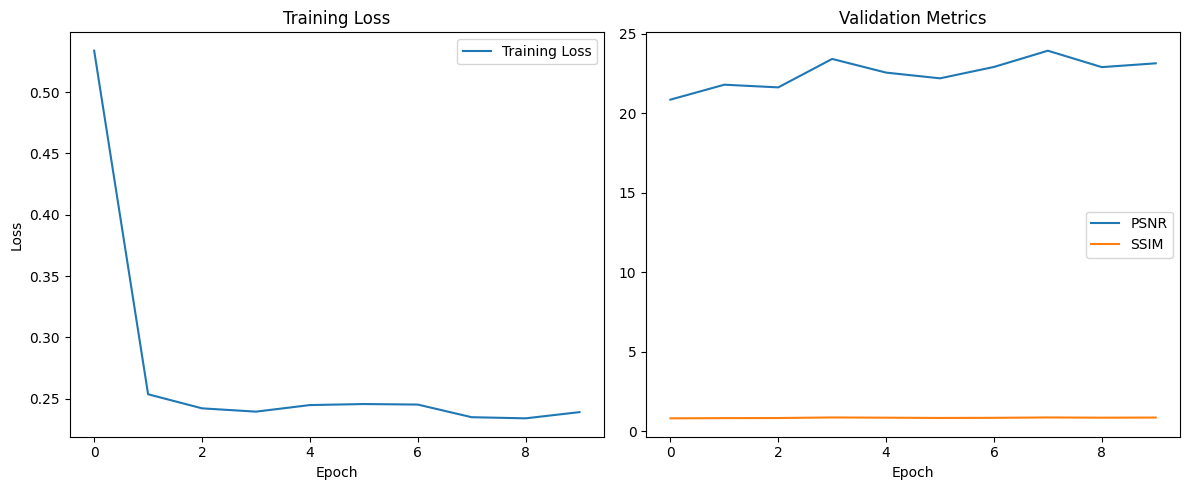


Final Test Results:
Test Loss: 0.2332
Test PSNR: 23.2307
Test SSIM: 0.8588
Test MSE: 0.0048


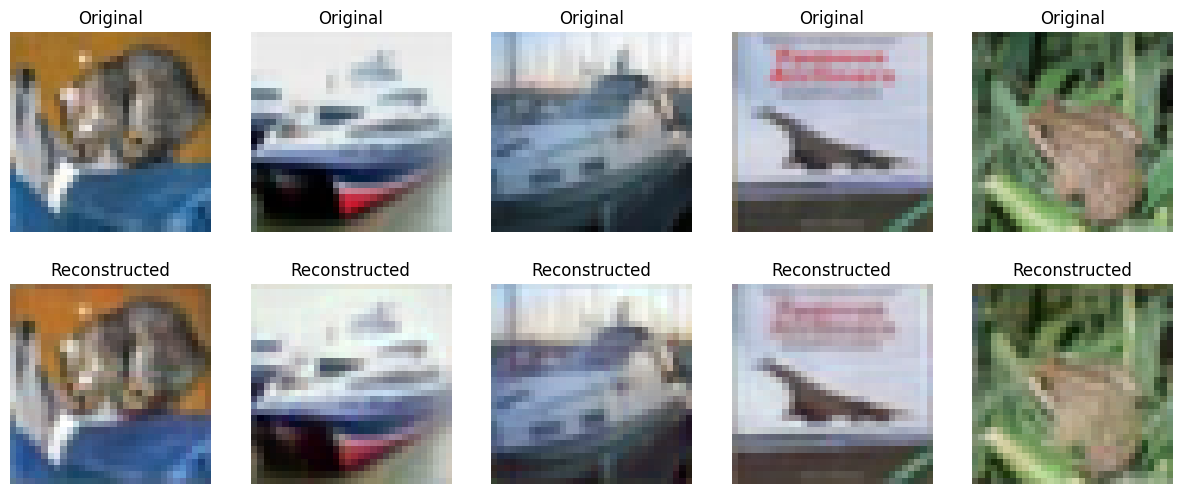

In [13]:
# Load a small dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Use a subset of CIFAR-10 for faster training
full_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

# Create a smaller subset for faster training
subset_size = 10000
train_size = int(0.8 * subset_size)
val_size = subset_size - train_size

subset_dataset, _ = random_split(
    full_dataset,
    [subset_size, len(full_dataset) - subset_size]
)

train_dataset, val_dataset = random_split(subset_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize models
model = UNet(num_classes=10).to(device)

# Use a pre-trained model as teacher (مدل از قبل ترین شده یونت پیدا نشد پس از وی جی جی استفاده میکنیم)
teacher_model = models.vgg11(pretrained=True)
# Remove the classifier part to get features
teacher_model = nn.Sequential(*list(teacher_model.features.children())[:8]).to(device)

# Train the model
num_epochs = 10
train_losses, val_metrics = train_model(
    model, train_loader, val_loader, teacher_model, device, num_epochs
)

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
val_psnr = [m['psnr'] for m in val_metrics]
val_ssim = [m['ssim'] for m in val_metrics]
plt.plot(val_psnr, label='PSNR')
plt.plot(val_ssim, label='SSIM')
plt.xlabel('Epoch')
plt.title('Validation Metrics')
plt.legend()

plt.tight_layout()
plt.savefig('training_progress.png')
plt.show()

# Test the model
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_results = evaluate_model(model, test_loader, teacher_model, device)

print("\nFinal Test Results:")
print(f"Test Loss: {test_results['total_loss']:.4f}")
print(f"Test PSNR: {test_results['psnr']:.4f}")
print(f"Test SSIM: {test_results['ssim']:.4f}")
print(f"Test MSE: {test_results['mse']:.4f}")

# Visualize some reconstructions
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    output = model(data)
    recon = output[:, -3:]

    # Denormalize
    data = data * 0.5 + 0.5
    recon = recon * 0.5 + 0.5

    # Plot some examples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axes[0, i].imshow(data[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(recon[i].cpu().permute(1, 2, 0))
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.savefig('reconstruction_examples.png')
    plt.show()